In [ ]:
from qutip import *
import numpy as np
import scipy.optimize as sciop
import matplotlib.pyplot as plt
import cython
import skopt

# define idealised basis
basis_labels = {
    'cav_bin': 0,
    'spont_bin': 1,
    'g':2,
    'u':3,
    'x':4
}
N=len(basis_labels)

g_ket = basis(N, basis_labels['g'])
u_ket = basis(N, basis_labels['u'])
x_ket = basis(N, basis_labels['x'])

# define basic operators
gx_swap = basis(N, basis_labels['g']) * basis(N, basis_labels['x']).dag()
ux_swap = basis(N, basis_labels['u']) * basis(N, basis_labels['x']).dag()

g_id = fock_dm(N, basis_labels['g'])
u_id = fock_dm(N, basis_labels['u'])
x_id = fock_dm(N, basis_labels['x'])
cav_id = fock_dm(N, basis_labels['cav_bin'])
spont_id = fock_dm(N, basis_labels['spont_bin'])

cav_decay = basis(N, basis_labels['cav_bin']) * basis(N, basis_labels['g']).dag()
spont_decay = basis(N, basis_labels['spont_bin']) * basis(N, basis_labels['x']).dag()

In [ ]:
gamma = 2*np.pi
kappa = gamma*1

coops = [1,1.5,2,2.5,3,3.5,4,5,8,10,15,17,20,30,40,50,80,100,120, 130, 140,150, 170, 190, 210]
# omg_guesses = [5,10,40,45,60,21,25,33,36,46.8,46.4,51.3,67.7,96.7,108.8,122.7]
kappas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]


RUNTIME = 10/gamma
STEPS_PER_SEC = 1000
NUM_STEPS = round(STEPS_PER_SEC*RUNTIME + 1)
if type(RUNTIME) == float:
    if RUNTIME < 1:
        lin_factor = 1/RUNTIME
        RUNTIME = lin_factor*RUNTIME
    else:
        lin_factor = 10
        RUNTIME = np.ceil(RUNTIME*10)
else:
    lin_factor = 1
t = np.linspace(0, int(RUNTIME), NUM_STEPS)
t /= lin_factor

In [ ]:
a_0 = 7938/18608
a_1 = 9240/18608
a_2 = 1430/18608
T = RUNTIME

# define pulse shape
wSTIRAP = np.pi/RUNTIME
H_args = {
    'wSTIRAP': wSTIRAP,
    'a0': a_0,
    'a1': a_1,
    'a2': a_2,
    'T': T
}

sin_pulse = 'omega*np.sin(wSTIRAP*t)**2'
blackman = 'omega*(a0 - a1*np.cos(2*pi*t/T) + a2*np.cos(4*pi*t/T))'

opts = Options(rhs_reuse=True)

In [ ]:
omega_guess_old = [97.1, 96.8,96.3, 96, 95.6, 94.9, 94.3, 92.7, 92, 91.4, 91.9, 93.6, 99, 106.9, 128, 148.5, 231.8, 290.2, 340,350, 360, 413.9]
omega_guess = []
for guess in omega_guess_old:
    omega_guess.append(guess+2200)
omega_guess += [3000]*3
current_kappa = 1

In [ ]:
def find_efficiency(omega, delta, cooperativity, kappa_ratio, psi0=u_ket, pulse_shape=sin_pulse):

    omega *= 2*np.pi
    delta *= 2*np.pi
    kappa = kappa_ratio * gamma
    H_args['omega'] = omega
    
    global current_kappa

    if kappa != current_kappa:
        opts.rhs_reuse = False
        current_kappa = kappa

    g0 = (2*kappa*gamma*cooperativity)**0.5

    H0 = delta*g_id + delta*u_id - g0*(gx_swap + gx_swap.dag())
    H1 = -1/2*(ux_swap + ux_swap.dag())
    H=[H0, [H1, pulse_shape]]

    c_ops = [np.sqrt(gamma)*spont_decay, np.sqrt(kappa)*cav_decay]

    result = mesolve(H, psi0, t, c_ops, [], args=H_args, options=opts)
    
    photon_emission_prob = expect(cav_id, result.states[-1])

    opts.rhs_reuse = True

    if photon_emission_prob > 1e-7:
        return photon_emission_prob
    else:
        return 0


In [ ]:
max_delta = 20
omg_factor = 5
min_omg_factor = 0
max_omg_test = 1.5e4

def optimise_peak_rabi(cooperativity, omega_guess, delta):
    delta *= 2*np.pi

    def find_neg_efficiency(omega_delta, psi0=u_ket, pulse_shape=sin_pulse):

        omg = omega_delta[0]*2*np.pi

        g0 = (2*kappa*gamma*cooperativity)**0.5

        H0 = delta*g_id + delta*u_id - g0*(gx_swap + gx_swap.dag())
        H1 = -omg/2*(ux_swap + ux_swap.dag())
        H=[H0, [H1, pulse_shape]]

        result = mesolve(H, psi0, t, c_ops, [], args=H_args)

        photon_emission_prob = expect(cav_id, result.states[-1])
        spont_decay_prob = expect(spont_id, result.states[-1])

        if photon_emission_prob + spont_decay_prob > 1e-7:

            return -photon_emission_prob/(photon_emission_prob + spont_decay_prob)
        else:
            return 0
    
    return skopt.gp_minimize(find_neg_efficiency, [[omega_guess*min_omg_factor, max_omg]],x0=[omega_guess], n_calls=30)


def optimise_peak_rabi_delta(inputs):
    cooperativity = inputs[0]
    omega_guess = inputs[1]
    delta_guess = inputs[2]
    kappa_ratio = inputs[3]

    def find_neg_efficiency(omega_delta, psi0=u_ket, pulse_shape=sin_pulse):
        omega = 2*np.pi * omega_delta[0]
        delta = 2*np.pi * omega_delta[1]
        kappa = kappa_ratio * gamma
        H_args['omega'] = omega
        
        global current_kappa

        if kappa != current_kappa:
            opts.rhs_reuse = False
            current_kappa = kappa

        g0 = (2*kappa*gamma*cooperativity)**0.5

        H0 = delta*g_id + delta*u_id - g0*(gx_swap + gx_swap.dag())
        H1 = -1/2*(ux_swap + ux_swap.dag())
        H=[H0, [H1, pulse_shape]]

        c_ops = [np.sqrt(gamma)*spont_decay, np.sqrt(kappa)*cav_decay]

        result = mesolve(H, psi0, t, c_ops, [], args=H_args, options=opts)
        
        photon_emission_prob = expect(cav_id, result.states[-1])

        opts.rhs_reuse = True

        if photon_emission_prob > 1e-7:
            return -photon_emission_prob
        else:
            return 0

    max_omg = omg_factor*omega_guess
    
    return skopt.gp_minimize(find_neg_efficiency, [[omega_guess*min_omg_factor, max_omg], [0, max_delta]],x0=[omega_guess, delta_guess], n_calls=100)

In [ ]:
def new_optimise_peak_rabi_delta(input):
   
    kappa_ratio = input[3]
    delta = input[2]
    omega_0 = input[1]
    cooperativity = input[0]

    resolution_levels = [50, 10, 5, 1, 0.5, 0.1]

    initial_eff = find_efficiency(omega_0, delta, cooperativity, kappa_ratio)

    for res in resolution_levels:
        finished = False
        new_step = 0
        while not finished:
    

            if new_step == 0:
                temp_effs = [initial_eff, find_efficiency(omega_0-res, delta, cooperativity, kappa_ratio), find_efficiency(omega_0+res, delta, cooperativity, kappa_ratio)]
            elif new_step == 1:
                temp_effs = [initial_eff, temp_effs[0], find_efficiency(omega_0+res, delta, cooperativity, kappa_ratio)]
            else:
                temp_effs = [initial_eff, find_efficiency(omega_0-res, delta, cooperativity, kappa_ratio), temp_effs[0]]
           

            if np.argmax(temp_effs) == 0:
                finished = True
            elif np.argmax(temp_effs) == 1 and temp_effs[1] > temp_effs[2]:
                
                omega_0 -= res
                new_step = -1
            else:
                
                omega_0 += res
                new_step = 1
            
            initial_eff = max(temp_effs)
    
    if omega_0 < 0:
        omega_0*=-1

    return [omega_0, initial_eff]


In [ ]:
def combined_optimise_peak_rabi_delta(inputs):
    cooperativity = inputs[0]
    omega_guess = inputs[1]
    delta_guess = inputs[2]
    kappa_ratio = inputs[3]

    bayesian_op_data = optimise_peak_rabi_delta(inputs)
    bayesian_omg, bayesian_delt = bayesian_op_data.x

    opt_omg, opt_eff= new_optimise_peak_rabi_delta([cooperativity, bayesian_omg, bayesian_delt, kappa_ratio])

    return [opt_omg, bayesian_delt, opt_eff]
    

In [ ]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()


input_args = []
for j in range(len(kappas)):
    sub_input_args = [[coops[k], omega_guess[k], 0, kappas[j]] for k in range(len(coops))]
    input_args.append(sub_input_args)

output_list = []
first_run = True
for input_set in input_args:
    if not first_run:
        for k in range(len(input_set)):
            input_set[k][1] = processed_list[k][0]
    if __name__ == "__main__":
        inputs = tqdm(input_set)
        processed_list = Parallel(n_jobs=num_cores)(delayed(combined_optimise_peak_rabi_delta)(i) for i in inputs)
        output_list.append(processed_list)
    first_run = False


 64%|██████▍   | 16/25 [10:47<06:48, 45.42s/it]

ValueError: x and y must have same first dimension, but have shapes (37,) and (27,)

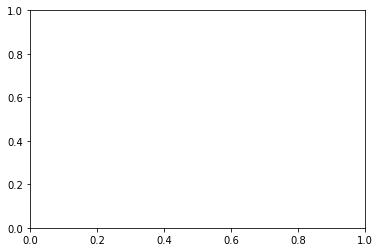

In [ ]:
fig, axes = plt.subplots(1,1)
k=0
for data_set in output_list:
    sub_omgs = [data[0] for data in data_set]
    sub_delts = [data[1] for data in data_set]
    sub_effs = [data[2] for data in data_set]
    np.savetxt(f'sin^2 2D, gamma=2pi, t=10gamma^-1, kappa_ratio = {kappas[k]}.gz', data_set)
    k+=1
    
    axes.plot(coops, sub_effs)


axes.plot(coops, [2*C/(2*C+1) for C in coops], 'k--', label='Benchmark')
axes.set_xscale('log')
axes.set_yscale('log')
fig.legend()

Text(0.5, 1.0, '$\\gamma=2\\pi$, $\\sin^2$ pulse, t=10/$\\gamma$')

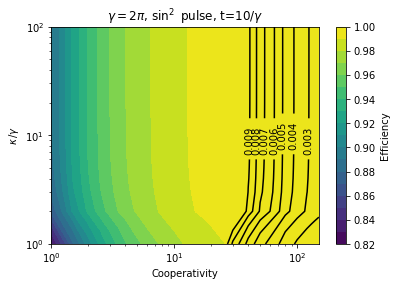

In [ ]:
grand_efficiencies = []
for data_set in output_list:
    efficiencies = [data[2] for data in data_set]
    grand_efficiencies.append(efficiencies)

X, Y = np.meshgrid(coops, kappas)

fig, axes = plt.subplots(1,1)
cp = axes.contourf(X,Y, grand_efficiencies, levels = 20)
axes.set_xscale('log')
axes.set_yscale('log')
cbar = fig.colorbar(cp)
cbar.set_label('Efficiency')

bench_eff = [2*C/(2*C+1) for C in coops]
grand_bench_eff = [bench_eff for j in range(len(kappas))]

grand_diff_effs = []
for j in range(len(kappas)):
    diff_effs = [grand_efficiencies[j][k] - grand_bench_eff[j][k] for k in range(len(coops))]
    grand_diff_effs.append(diff_effs)

cont = axes.contour(X,Y,grand_diff_effs,[0.002, 0.003,0.004,0.005, 0.006, 0.007, 0.008, 0.009], colors = 'k')
axes.clabel(cont, inline=True)
axes.set_xlabel('Cooperativity')
axes.set_ylabel('$\kappa\,/\gamma$')
axes.set_title('$\gamma=2\pi$, $\sin^2$ pulse, t=10/$\gamma$')

In [ ]:
bench_eff = [2*C/(2*C+1) for C in coops]
grand_bench_eff = [bench_eff for j in range(len(kappas))]

grand_diff_effs = []
for j in range(len(kappas)):
    diff_effs = [grand_efficiencies[j][k] - grand_bench_eff[j][k] for k in range(len(coops))]
    grand_diff_effs.append(diff_effs)

Text(0.5, 1.0, '$\\gamma=2\\pi$, $\\sin^2$ pulse, t=10/$\\gamma$')

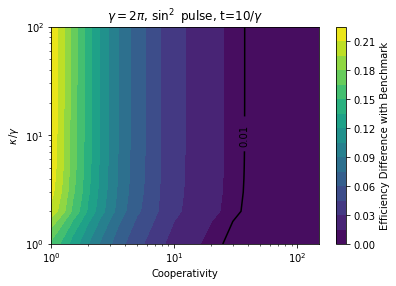

In [ ]:
X, Y = np.meshgrid(coops, kappas)

fig, axes = plt.subplots(1,1)
cp = axes.contourf(X,Y, grand_diff_effs, levels = 20)
axes.set_xscale('log')
axes.set_yscale('log')

cbar = fig.colorbar(cp)
cbar.set_label('Efficiency Difference with Benchmark')
cont = axes.contour(X,Y,grand_diff_effs,[0.01], colors = 'k')
axes.clabel(cont)
axes.set_xlabel('Cooperativity')
axes.set_ylabel('$\kappa\,/\gamma$')
axes.set_title('$\gamma=2\pi$, $\sin^2$ pulse, t=10/$\gamma$')



In [ ]:
np.savetxt('Grand Effs t=10gamma, sin^2.gz', grand_efficiencies)

In [ ]:
v=[0,1,2,3,4]
print(v[1:])

[1, 2, 3, 4]
